In [1]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", input_shape=IMAGE_SHAPE+(3,))
])

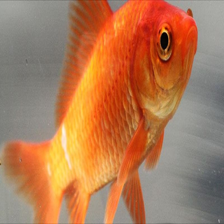

In [3]:
gold_fish = Image.open("goldfish.jpg").resize(IMAGE_SHAPE)
gold_fish

In [6]:
gold_fish = np.array(gold_fish)/255.0
gold_fish

array([[[0.57254902, 0.58039216, 0.56078431],
        [0.57647059, 0.58431373, 0.56470588],
        [0.57254902, 0.58039216, 0.56078431],
        ...,
        [0.61176471, 0.61568627, 0.59607843],
        [0.60392157, 0.60784314, 0.58823529],
        [0.61568627, 0.61960784, 0.6       ]],

       [[0.64313725, 0.65098039, 0.63137255],
        [0.64313725, 0.65098039, 0.63137255],
        [0.64705882, 0.65490196, 0.63529412],
        ...,
        [0.66666667, 0.67058824, 0.65098039],
        [0.6745098 , 0.67843137, 0.65882353],
        [0.6745098 , 0.67843137, 0.65882353]],

       [[0.63921569, 0.64705882, 0.62745098],
        [0.64313725, 0.65098039, 0.63137255],
        [0.63921569, 0.64705882, 0.62745098],
        ...,
        [0.65882353, 0.6627451 , 0.64313725],
        [0.65882353, 0.6627451 , 0.64313725],
        [0.65490196, 0.65882353, 0.63921569]],

       ...,

       [[0.59215686, 0.59607843, 0.56470588],
        [0.6       , 0.60392157, 0.57254902],
        [0.59607843, 0

In [8]:
gold_fish[np.newaxis,...].shape         ## Here 1 is the batch size

(1, 224, 224, 3)

In [10]:
result = classifier.predict(gold_fish[np.newaxis,...])

1/1 [==============================] - 0s 18ms/step


In [11]:
result.shape

(1, 1001)

In [12]:
predicted_label_index = np.argmax(result)

In [13]:
predicted_label_index

2

### Get predicted labels from imagenetlabels.txt

In [15]:
image_labels = []
with open('imagenetlabels.txt',"r") as f:
    image_labels = f.read().splitlines()
image_labels[:5]

['background', 'tench', 'goldfish', 'great white shark', 'tiger shark']

### Download FLowers dataset from google

In [16]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='.', untar=True)

228813984/228813984 [==============================] - 39s 0us/step


#### Used to convert string path obtained above to WindowsPath as shown below

In [18]:
import pathlib 
data_dir = pathlib.Path(data_dir)

In [19]:
data_dir

WindowsPath('datasets/flower_photos')

In [22]:
list(data_dir.glob("*/*.jpg"))[:5]  #Useful to do browsing and fetch operations

[WindowsPath('datasets/flower_photos/daisy/100080576_f52e8ee070_n.jpg'),
 WindowsPath('datasets/flower_photos/daisy/10140303196_b88d3d6cec.jpg'),
 WindowsPath('datasets/flower_photos/daisy/10172379554_b296050f82_n.jpg'),
 WindowsPath('datasets/flower_photos/daisy/10172567486_2748826a8b.jpg'),
 WindowsPath('datasets/flower_photos/daisy/10172636503_21bededa75_n.jpg')]

In [24]:
roses = list(data_dir.glob("roses/*.jpg"))[:5]

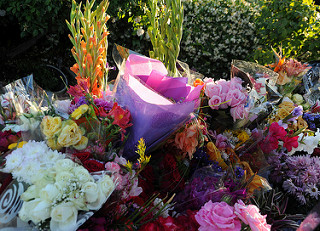

In [28]:
Image.open(roses[3])

In [29]:
tulips = list(data_dir.glob("tulips/*.jpg"))[:5]

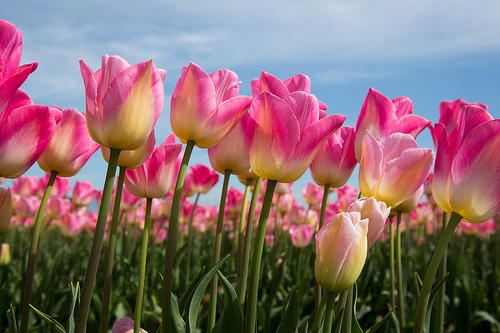

In [30]:
Image.open(tulips[3])

### Read flowers images from disk into numpy array using opencv

In [31]:
flowers_images_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),
}

In [32]:
flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4,
}

In [33]:
flowers_images_dict['roses'][:5]

[WindowsPath('datasets/flower_photos/roses/10090824183_d02c613f10_m.jpg'),
 WindowsPath('datasets/flower_photos/roses/102501987_3cdb8e5394_n.jpg'),
 WindowsPath('datasets/flower_photos/roses/10503217854_e66a804309.jpg'),
 WindowsPath('datasets/flower_photos/roses/10894627425_ec76bbc757_n.jpg'),
 WindowsPath('datasets/flower_photos/roses/110472418_87b6a3aa98_m.jpg')]

In [34]:
img = cv2.imread(str(flowers_images_dict['roses'][0]))

In [35]:
img.shape

(240, 179, 3)

In [36]:
cv2.resize(img,(224,224)).shape

(224, 224, 3)

In [37]:
X, y = [], []

for flower_name, images in flowers_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(224,224))
        X.append(resized_img)
        y.append(flowers_labels_dict[flower_name])

In [38]:
X = np.array(X)
y = np.array(y)

## Train test split

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

### Preprocessing: scale images

In [40]:
X_train_scaled = X_train / 255.0
X_test_scaled = X_test / 255.0

#### Make prediction using pre-trained model on new flowers dataset

In [42]:
X_train_scaled.shape

(2752, 224, 224, 3)

In [43]:
X_test_scaled.shape

(918, 224, 224, 3)

#### Now take pre-trained model and retrain it using flowers images

In [47]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [48]:
num_of_flowers = 5

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_flowers)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [49]:
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
86/86 [==============================] - 5s 27ms/step - loss: 0.7911 - acc: 0.7071
Epoch 2/5
86/86 [==============================] - 2s 27ms/step - loss: 0.4091 - acc: 0.8645
Epoch 3/5
86/86 [==============================] - 2s 29ms/step - loss: 0.3206 - acc: 0.8957
Epoch 4/5
86/86 [==============================] - 2s 29ms/step - loss: 0.2661 - acc: 0.9164
Epoch 5/5
86/86 [==============================] - 2s 28ms/step - loss: 0.2329 - acc: 0.9324


In [50]:
model.evaluate(X_test_scaled,y_test)

29/29 [==============================] - 2s 37ms/step - loss: 0.3732 - acc: 0.8704


[0.37315449118614197, 0.8703703880310059]